1. How to make it available for marking? (eg is slack they say make TAs collaborators or make it public)
Answer: See slack, need to inlcude TAs as collaboators on GH
2. distnace matrix h as eucledian distances squared (good in code, check in proofs)
3. scale legs??
4. isomap converge to pca at already around 50
5. leg is most influential attribute, show loadings

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

https://joellaity.com/2018/10/18/pca.html

## 1. Import Packages

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
import scipy.linalg as la
import pandas as pd
import seaborn as sns

## 2. Functions and helpers

In [2]:
def is_symmetric(A, rtol=1e-05, atol=1e-08):
    """ Checks if matrix A is symmetric.
    
    Parameters
    ----------
    A : numpy.ndarray
        The matrix.
        
    rtol : float
        Relative tolerance.
    
    atol : float
        Absolute tolerance.
        
    Returns
    -------
    bool
        True if the matrix is symmetric.
    """
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

In [3]:
def data_centering(Y_uncentered, tol=10e-10):
    """ Center the data matrix, that is, subtract the mean of each feature space from the features of each
    data point/vector. Pre-requisite for PCA and MDS.
    
    Parameters
    ----------
    Y_uncentered : numpy.ndarray
        The uncentered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
    """
    # Data centering (subtract mean of each column/feature from each entry in that column).
    # Use Numpy broadcasting.
    Y = Y_uncentered - Y_uncentered.mean(axis=0).astype(np.float64)
    
    assert all(Y.mean(axis=0) < tol), "Data centering was unsuccesful."
    
    return Y

## 2. Read data

In [4]:
# Read data frame with no header.
df = pd.read_csv("zoo.data", header=None)

# Name columns (no header previously).
df.columns = ["animal name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator",
             "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]

# Show some rows.
print(df.shape)
df.head(20)

(101, 18)


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,1
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0,1


## 3. EDA (Exploaratory data analysis)

/home/mark/anaconda3/envs/ml_adv_ass_1_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


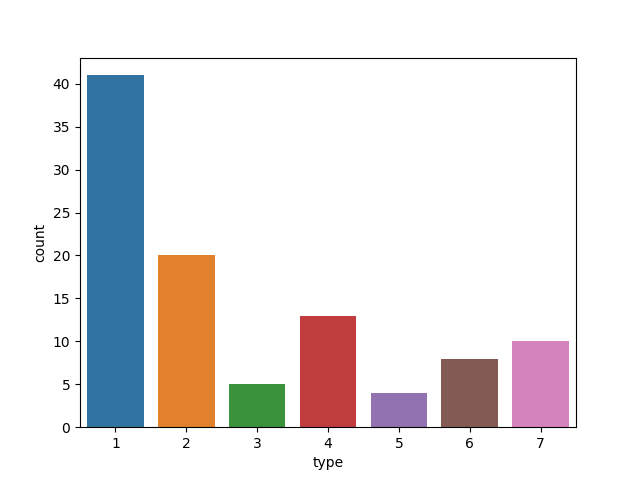

<AxesSubplot:xlabel='type', ylabel='count'>

In [5]:
# Show observation frequencies in classes.
sns.countplot(df['type'],label="Count")

<IPython.core.display.Javascript object>


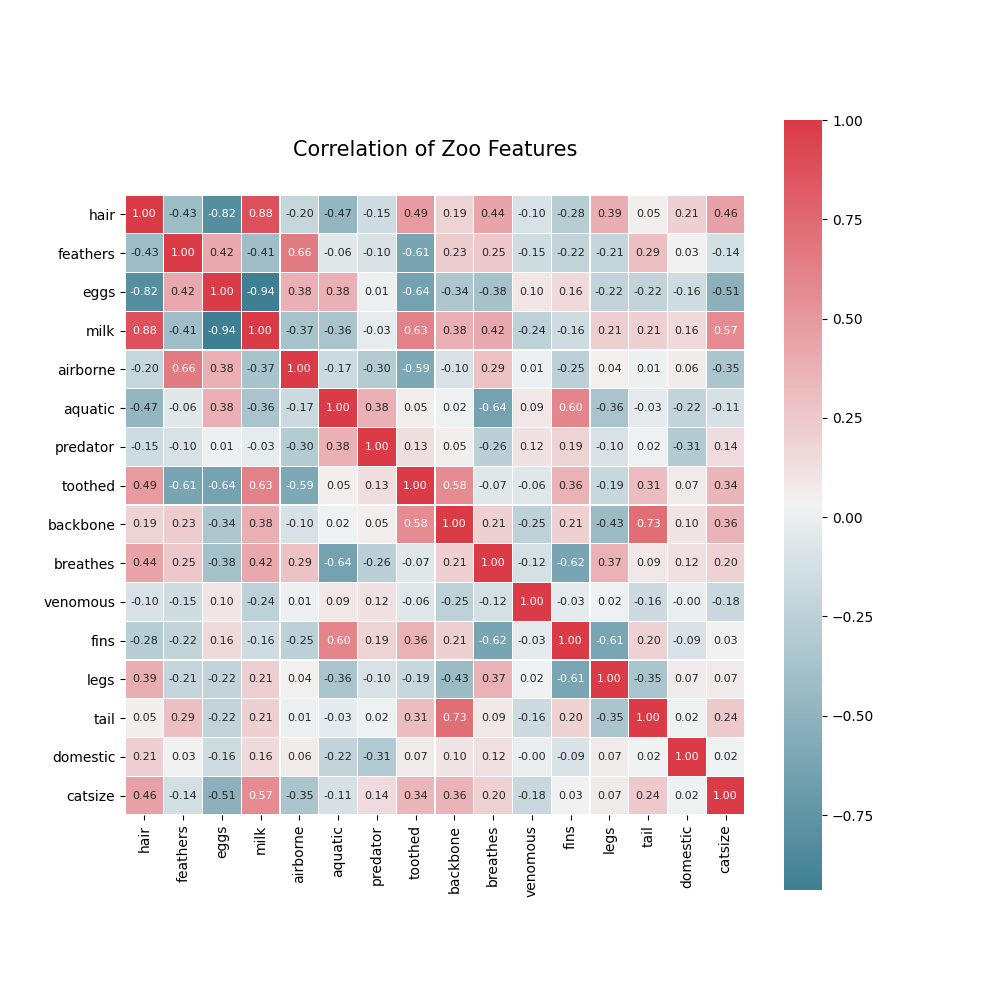

Text(0.5, 1.05, 'Correlation of Zoo Features')

In [6]:
# Show correlations. E.g.: hair - milk is high = mammals have hair and milk
corr = df.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Zoo Features', y=1.05, size=15) 

## 4. Dimensionality Reduction

### 4.1 Principal Component Analysis (PCA)

In [7]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)

print("The data matrix is:")
print(Y_uncentered)
print("\n")
print(f"The shape of the data matrix is: {Y_uncentered.shape}")

The data matrix is:
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


The shape of the data matrix is: (101, 16)


In [8]:
# Data centering.
Y = data_centering(Y_uncentered=Y_uncentered)

In [9]:
# Do PCA on centered data and embed data into 2 dimensions.
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(Y)

In [10]:
index = ["hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator",
         "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize",]
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=index)
print(loadings)
print("\n")

explained_variance = sum(pca.explained_variance_ratio_)
print(f"The explained variance of the first {n_components} principal components is: {explained_variance*100:.2f}%")

               PC1       PC2
hair      0.104560 -0.383470
feathers -0.041193  0.175622
eggs     -0.063451  0.440325
milk      0.061244 -0.450889
airborne  0.008719  0.213197
aquatic  -0.093908  0.126039
predator -0.029338 -0.017405
toothed  -0.041852 -0.399159
backbone -0.077852 -0.221520
breathes  0.079763 -0.112074
venomous  0.002239  0.050129
fins     -0.113607 -0.025998
legs      0.967811  0.082058
tail     -0.073733 -0.167216
domestic  0.014434 -0.049298
catsize   0.021173 -0.319383


The explained variance of the first 2 principal components is: 77.06%


In [11]:
df_pca = pd.DataFrame({'PC 1': X_pca[:, 0], 'PC 2': X_pca[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_pca.shape)
df_pca.head(20)

(101, 4)


,PC 1,PC 2,animal name,type
0,1.351029,-1.058533,aardvark,1
1,1.306634,-1.208344,antelope,1
2,-3.131655,0.252200,bass,4
3,1.351029,-1.058533,bear,1
4,1.277296,-1.225750,boar,1
5,1.306634,-1.208344,buffalo,1
6,1.321069,-1.257643,calf,1
7,-3.087882,0.220307,carp,4
8,-3.131655,0.252200,catfish,4
9,1.373629,-0.771044,cavy,1


<IPython.core.display.Javascript object>


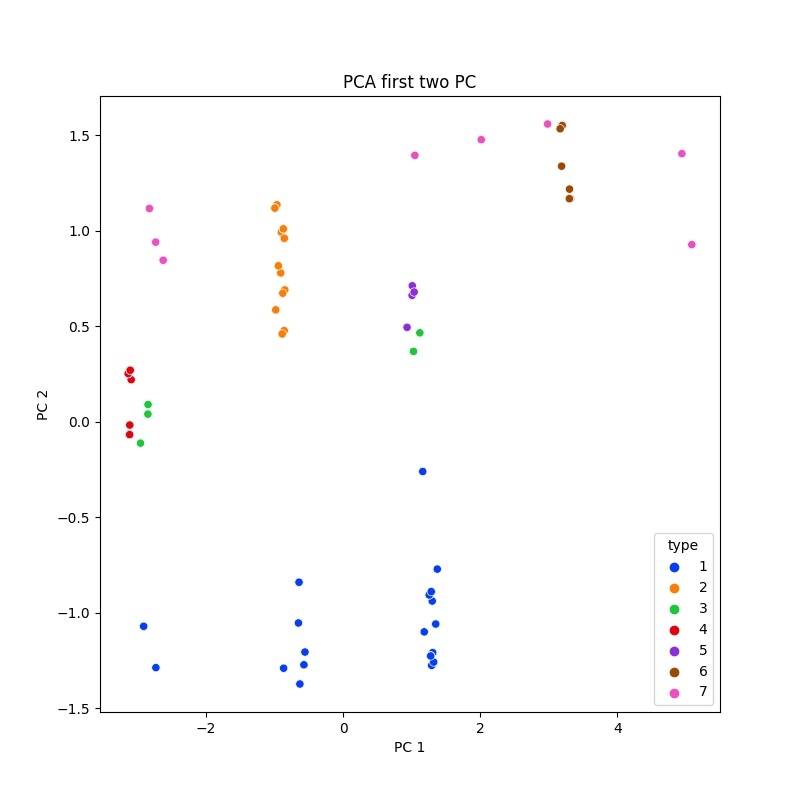

Text(0.5, 1.0, 'PCA first two PC')

In [12]:
# Generate figure.
fig= plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="type", palette="bright")

ax.set_title("PCA first two PC")

### 4.2 Multi-Dimensional Scaling (MDS)

In [13]:
def squared_distance_marix_from_data(Y):
    """ Derive the pairwise distance matrix from the data matrix.
    
    Parameters
    ----------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
    """
    D = euclidean_distances(Y)
    D = np.power(D, 2)
    
    assert is_symmetric(A=D), "The distance matrix is D non-symmetric."
    
    return D

In [14]:
def double_centering(D):
    """ Double centering trick to derive a similarity matrix from a pairwise distance matrix for 
    inputting to MDS.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
        
    Returns
    -------
    S : numpy.ndarray
        Gram matrix or pairwise similarity matrix (symmetric, real). The input to the MDS algorithm.
    """
    # Derive the Gram matrix of the data matrix from the distance matrix D. Use Numpy broadcasting to: 
    # (1) subtract from each entry of D the mean of the corresponding row
    # (2) subtract the mean of the corresponding column
    # (3) add back the mean of all entries
    S = -0.5 * (D - D.mean(axis=1).reshape(D.shape[0],1) - D.mean(axis=0).reshape(1,D.shape[0]) + D.mean())
    
    return S

In [15]:
def mds_from_squared_distance_matrix(D):
    """ Multidimensional scaling (MDS) algorithm (classical MDS) with the pairwise distance matrix of the
    data matrix as input.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
        
    Returns
    -------
    X : numpy.ndarray
        Embedding of the data matrix from which the pairwise distance matrix D was derived.
        The shape of X is (J, N) where J is the dimension of the embedding.
        MDS is based on the eigendecomposition of the Gram matrix S (symmetric, real = real 
        eigenvalues and eigenvectors). Due to numerical stability issues, some eigenvalues close 
        to zero might end up being tiny negative numbers. As a result, X is the J dimensional representation/
        embedding of the data matrix where J corresponds to the number of strictily positive
        eigenvalues (J is lower than or equal to N).
    """
    # Get the Gram matrix.
    S = double_centering(D=D)
    
    # Eigendecomposition of S. Use the numpy.linalg.eigh to return the eigenvalues and 
    # eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix. 
    # Eigenvalues are in a 1-D matrix, eigenvectors are in a 2-D matrix of which each column is 
    # eigenvector at column index idx that corresponds to the eigenvalue at index idx among the 
    # eigenvalues.
    eigenvalues, eigenvectors = np.linalg.eigh(S)

    # Make sure that the eigenvalues and the eigenvectors are sorted in descending order based on the
    # eigenvalues.
    idx_descending   = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx_descending]
    eigenvectors = eigenvectors[:,idx_descending]
    
    # Only use the J positive eigenvalues and their corresponding eigenvectors to embed the data.                  
    idx_positive, = np.where(eigenvalues > 0)
    
    # Eigendecomposition with only the positive eigenvalues and their correspoinding eigenvectors.
    L  = np.diag(np.sqrt(eigenvalues[idx_positive]))
    U  = eigenvectors[:,idx_positive]
    
    # J dimensional embedding of the data matrix. Shape is (J, N). The best dimensions are at lower row indices. 
    X  = np.matmul(U, L)
    
    return X, eigenvalues

In [16]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)

print("The data matrix is:")
print(Y_uncentered)
print("\n")
print(f"The shape of the data matrix is: {Y_uncentered.shape}")

The data matrix is:
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


The shape of the data matrix is: (101, 16)


In [17]:
# Data centering.
Y = data_centering(Y_uncentered=Y_uncentered)

In [18]:
# Get the squared pairwise distance matrix of Y.
D = squared_distance_marix_from_data(Y=Y)
print(D)

[[ 0.  2. 24. ...  1. 23. 13.]
 [ 2.  0. 24. ...  1. 23. 11.]
 [24. 24.  0. ... 23.  7. 11.]
 ...
 [ 1.  1. 23. ...  0. 24. 12.]
 [23. 23.  7. ... 24.  0.  8.]
 [13. 11. 11. ... 12.  8.  0.]]


In [19]:
# Implement MDS on D.
X_mds, eigenvalues = mds_from_squared_distance_matrix(D=D)

In [20]:
# Create a DataFrame of the embedded data for visualization.
df_mds = pd.DataFrame({'Dimension 1': X_mds[:, 0], 'Dimension 2': X_mds[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_mds.shape)
df_mds.head(90)

(101, 4)


,Dimension 1,Dimension 2,animal name,type
0,-1.351029,-1.058533,aardvark,1
1,-1.306634,-1.208344,antelope,1
2,3.131655,0.252200,bass,4
3,-1.351029,-1.058533,bear,1
4,-1.277296,-1.225750,boar,1
...,...,...,...,...
85,-2.014445,1.476383,starfish,7
86,3.108244,-0.017053,stingray,4
87,0.942773,0.816241,swan,2
88,-3.185266,1.337733,termite,6


<IPython.core.display.Javascript object>


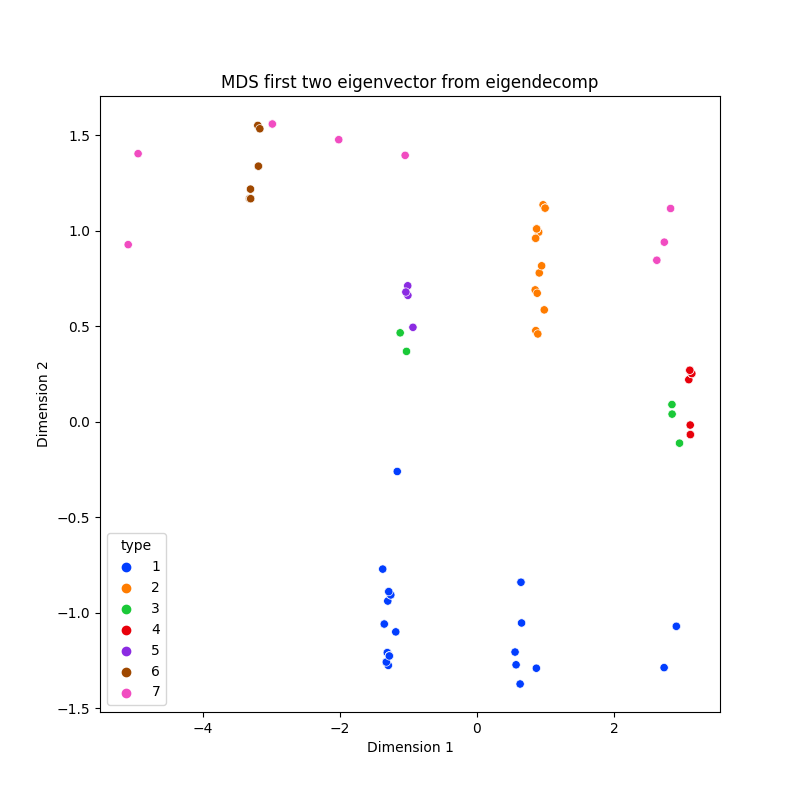

Text(0.5, 1.0, 'MDS first two eigenvector from eigendecomp')

In [21]:
# Visualize embedded data.
fig = plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df_mds, x="Dimension 1", y="Dimension 2", hue="type", palette="bright")

ax.set_title("MDS first two eigenvector from eigendecomp")

### 4.3 Isomap

In [22]:
def isomap(Y, k=None):
    """ Derives the shortest path graph of a data matrix Y from its squared pairwise distance matrix D while
    relying on the k-rule neighbourhood graph.
    
    Parameters
    ----------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
    
    k : int
        The integer of the k-rule that controls how many neighbours a vertex stays connected to in the 
        k-rule neighbourhood graph.
        
    Returns
    -------
    X_isomap : numpy.ndarray
        Data matrix embedded via isomap of shape (N, J) where J is the number of positive eigenvalues
        of the spectral decomposition of the shortest path matrix G.
    
    eigenvaues_isomap : numpy.ndarray
        The eigenvalues (in descending order) of the shortest path graph distance matrix.
        
    n_components : int
        The number of connected components in the k-nearest neigbourhood graph. If greater than or equal to 2, 
        the graph is disconnected.
    """
    # Assert that k is valid.
    assert k is not None and isinstance(k, int), "k needs to be an integer"
    
    # Get the connectivity graph for k-neaighbours for points in the centered data matrix Y.
    G_connectivity = kneighbors_graph(Y, mode="connectivity", n_neighbors=k, metric='minkowski', p=2).toarray()
    
    # Check if the graph is disconnected, i.e.: has at least 2 or more connected components
    n_components, labels = connected_components(csgraph=G_connectivity, directed=False, return_labels=True)
    
    # Get the Euclidean shortest path distance graph for k-neighbours for points in Y.
    G = kneighbors_graph(Y, mode="distance", n_neighbors=k, metric='minkowski', p=2).toarray()
    
    # Square the distances.
    G = np.power(G, 2)
    
    # Use the MDS on the the squared shortest path graph distance matrix G (G is symmetric).  
    X_isomap, eigenvaues_isomap = mds_from_squared_distance_matrix(D=G)
    
    return X_isomap, eigenvaues_isomap, n_components

In [23]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)

print("The data matrix is:")
print(Y_uncentered)
print("\n")
print(f"The shape of the data matrix is: {Y_uncentered.shape}")

The data matrix is:
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


The shape of the data matrix is: (101, 16)


In [24]:
# Data centering.
Y = data_centering(Y_uncentered=Y_uncentered)

In [25]:
k = 100
X_isomap, eigenvaues_isomap, n_components = isomap(Y=Y, k=k)
print(f"Conn comp: {n_components} ({'graph connected' if n_components == 1  else 'graph disconnected'})")

Conn comp: 1 (graph connected)


In [26]:
df_isomap = pd.DataFrame({'Dimension 1': X_isomap[:, 0], 'Dimension 2': X_isomap[:, 1], 
                          'animal name': df['animal name'], 'type': df['type']})
print(df_isomap.shape)
df_isomap.head(90)

(101, 4)


,Dimension 1,Dimension 2,animal name,type
0,-1.351029,-1.058533,aardvark,1
1,-1.306634,-1.208344,antelope,1
2,3.131655,0.252200,bass,4
3,-1.351029,-1.058533,bear,1
4,-1.277296,-1.225750,boar,1
...,...,...,...,...
85,-2.014445,1.476383,starfish,7
86,3.108244,-0.017053,stingray,4
87,0.942773,0.816241,swan,2
88,-3.185266,1.337733,termite,6


<IPython.core.display.Javascript object>


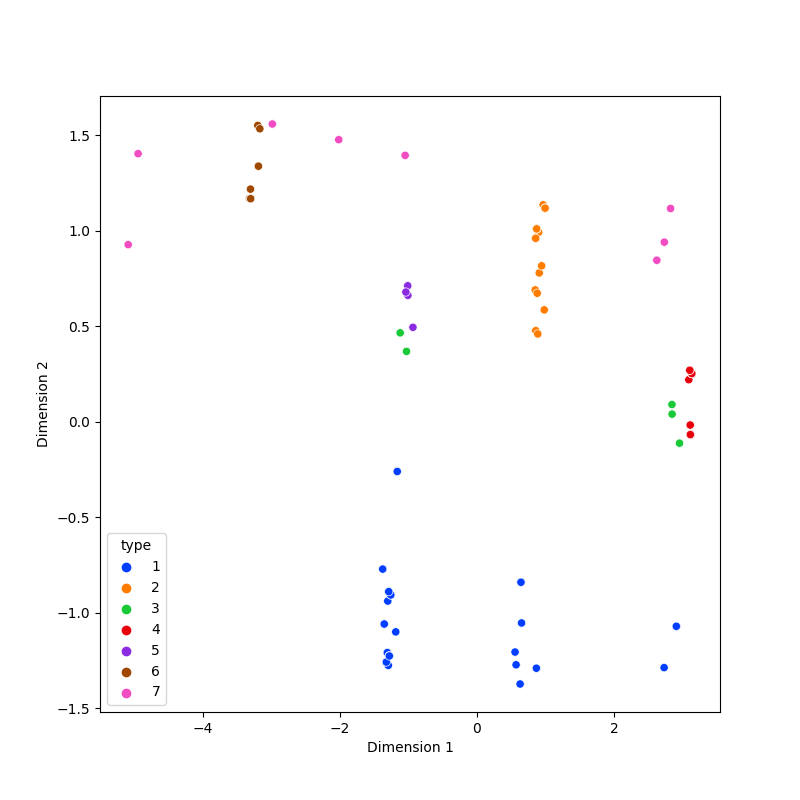

<AxesSubplot:xlabel='Dimension 1', ylabel='Dimension 2'>

In [27]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=df_isomap, x="Dimension 1", y="Dimension 2", hue="type", palette="bright")

Cell below: disable automatic scrolling extension of Juypter notebook to better show the sequence of subfigures.

In [28]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


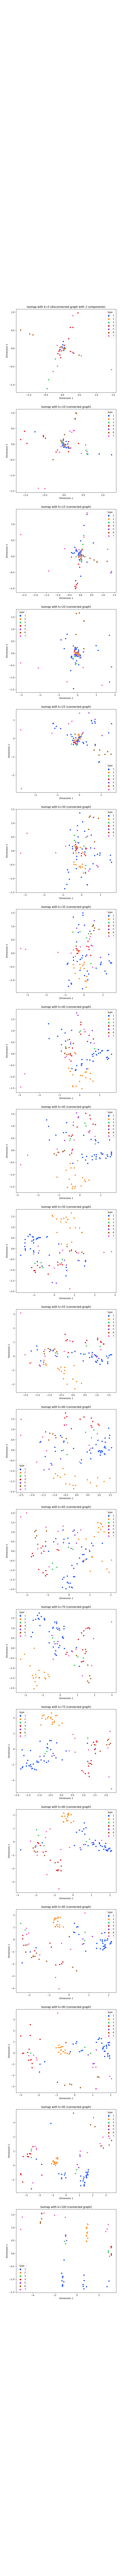

In [29]:
# Visualize Isomap for a range of k values in the k-nearest neighbor neighbourhood graph.

# Create a range of k values.
ks = [k for k in range(5,101,5)]

# Create a main figure its subfigures.
fig, axs = plt.subplots(nrows=len(ks), ncols=1, figsize=(8,8*len(ks)))

# Iterate over each k value, and plot the Isomap embedded data.
for k, ax in zip(ks, axs):
    
    # Get data matrix.
    Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
    
    # Center the data matrix.
    Y = data_centering(Y_uncentered=Y_uncentered)
    
    # Do Isomap.
    X_isomap, eigenvaues_isomap, n_components = isomap(Y=Y, k=k)
    
    # Convert embedded data into DataFrame for visualization.
    df_isomap = pd.DataFrame({'Dimension 1': X_isomap[:, 0], 'Dimension 2': X_isomap[:, 1], 
                          'animal name': df['animal name'], 'type': df['type']})
    
    # Visualize embedded data.
    sns.scatterplot(data=df_isomap, x="Dimension 1", y="Dimension 2", hue="type", palette="bright", ax=ax)
    
    # Get if the Isomap neighbourhood graph is disconnected.
    if_graph_connected = \
        'connected graph' if n_components == 1  else f'disconnected graph with {n_components} components'
    
    # Title the plot.
    ax.set_title(f"Isomap with k={k} ({if_graph_connected})")
    
plt.show()